In [1]:
from LIFTrainingGPU import *

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
p = create_default_params_LIF()

In [14]:
p['net_size'] = 1000
p['total_time'] = 1000
p['runtime'] = 1000
p['training_loops'] = 50

In [15]:
net = LIFTrainingGPU(p)

In [16]:
stim0 = np.zeros((p['net_size'], int(p['runtime']/p['dt'])))
stimr = net.gen_rand_stim(p) 

In [17]:
def gen_sine_targets(N, T, dt): 
    
    timesteps = int(T/dt)
    targets = np.zeros((N, timesteps))
    for i in range(N):
        amp = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, T, num = timesteps)
        targets[i] = amp * np.sin(2 * np.pi * (x - t0)/t1)
    fout = np.zeros(timesteps)
    return targets, fout

In [18]:
targ, fout = gen_sine_targets(net.N, net.T, net.dt)

In [19]:
# for i in range(5):
#     net.run_LIF(stimr)
net.trainGPU_LIF(stimr, targ, fout)

training: 0
training: 20
training: 40


In [20]:
voltage, slow, fast = net.run_LIF(stimr)

Text(0.5, 1.0, 'Behavior after training')

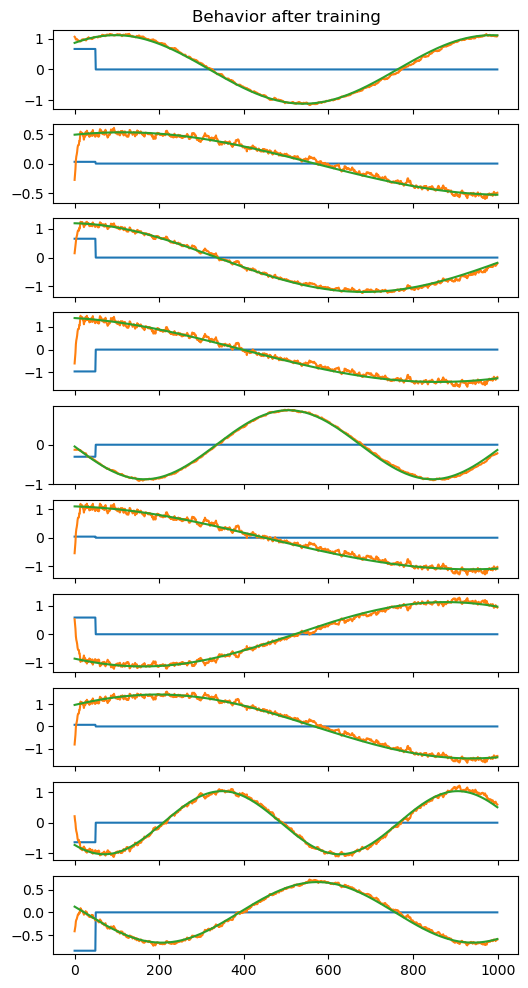

In [21]:
Jslow = np.dot(net.Js, slow)

n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(stimr[i])
    axs[i].plot(Jslow[i])
    axs[i].plot(targ[i])
axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Behavior after training')

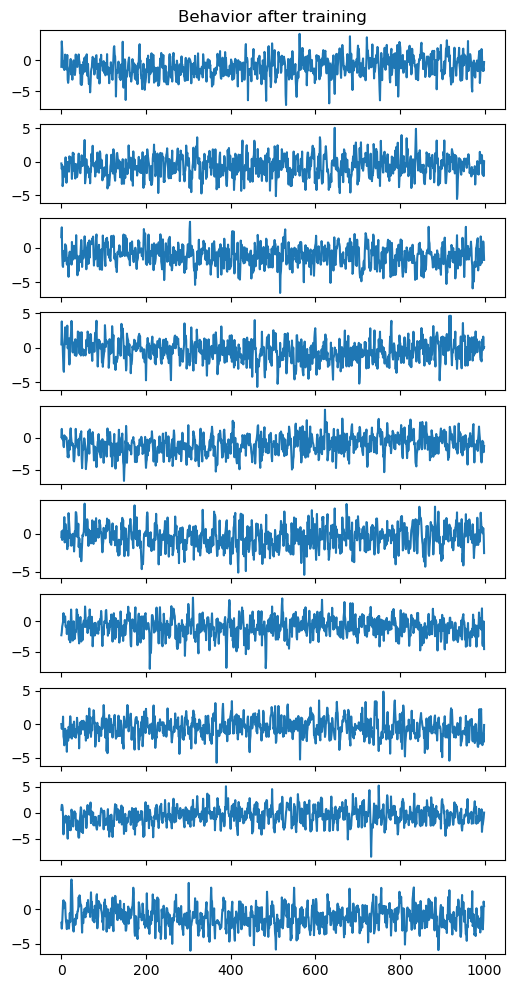

In [22]:
Jfast = np.dot(net.Jf, fast)

n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jfast[i])
axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Behavior after training')

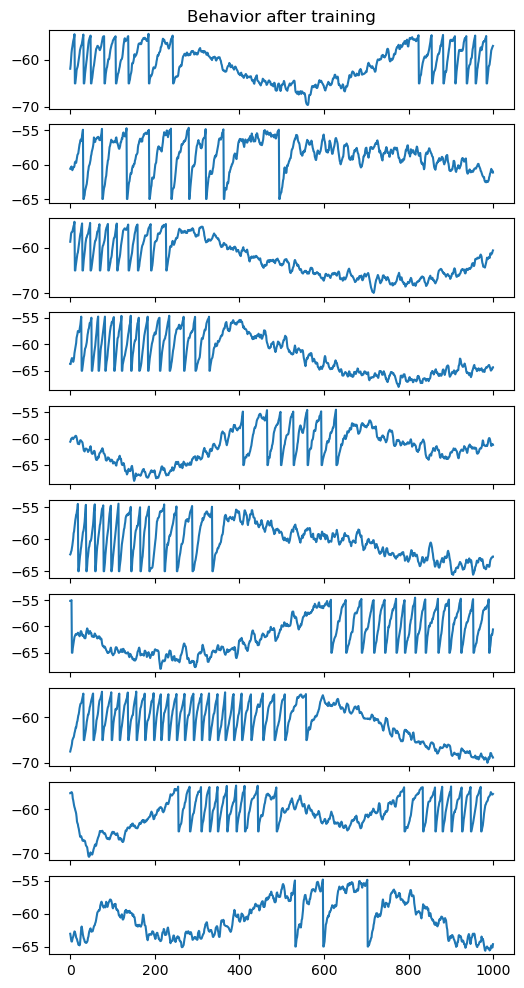

In [23]:
n_plot = 10
T = net.T
dt = net.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Behavior after training")

In [52]:
tau_f = 2
f = 1
dt = 1

In [53]:
for i in range(int(1/dt)):
    df = - dt/tau_f * f
    f = f + df
f

0.5